# Self-Attention Analysis

In [1]:
# based on: https://github.com/naver-ai/cl-vs-mim/blob/main/self_attention_analysis.ipynb
# goated xxxnell as always
import torch
import timm
import matplotlib.pyplot as plt
from functools import partial
from src.utils.analysis.clmim_hook import ActivationCache

In [2]:

# !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz -P ~/development/datasets
# !gunzip ~/development/datasets/imagenette2-160.tgz -d ~/development/datasets
# !tar -xvf ~/development/datasets/imagenette2-160.tar -C ~/development/datasets

In [3]:
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from src.models.components.cl_vs_mim.utils import subsample

#@markdown Execute this cell to download and import the *Imagenette* dataset, which is a small subset of ImageNet, for simplicity.

# use imagenette (a small subset of imagenet) as an example for simplicity
imagenet_path = "~/development/datasets/imagenette2-160"

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=224, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test, 
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test, 
    num_workers=1, 
    batch_size=64,
)

## Load the Models

In [4]:
def load_moco():
    import src.models.components.cl_vs_mim.moco as moco
    from src.models.components.cl_vs_mim.moco  import load_state_dict
    from src.models.components.cl_vs_mim.utils import download
    path = "../../artifacts/moco_vit_b.pt"  #@param {type:"string"}
    url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"  #@param {type:"string"}

    download(url, path, force=False)  # download checkpoints

    model = moco.vit_base()
    model = model.cuda()
    model = model.eval()

    state_dict = load_state_dict(path)
    _ = model.load_state_dict(state_dict, strict=False)
    return model

In [5]:
# SimMIM 
def load_simmmim():
    import src.models.components.cl_vs_mim.simmim as simmim
    from src.models.components.cl_vs_mim.simmim import load_state_dict
    path = "../../artifacts/simmim_vit_b.pth"  #@param {type:"string"}
    model = simmim.vit_base("../../src/models/components/cl_vs_mim/simmim_pretrain__vit_base__img224__800ep.yaml")
    model = model.cuda()
    model = model.eval()

    state_dict = load_state_dict(path)
    _ = model.load_state_dict(state_dict, strict=False)
    return model

In [6]:
def load_mae():
    return timm.create_model('vit_base_patch16_224.mae', pretrained=True).cuda().eval()

In [7]:
def load_dino():
    return timm.create_model('vit_base_patch16_224.dino', pretrained=True).cuda().eval()

def load_dinov2():
    return timm.create_model('vit_base_patch14_dinov2.lvd142m', pretrained=True, img_size=224, patch_size=16).cuda().eval()

In [8]:
def load_part_v1(ckpt_path, dir_name):
    import argparse
    torch.serialization.add_safe_globals([argparse.Namespace])
    ckpt = torch.load(ckpt_path, weights_only=True)
    kwargs = {
            "num_classes": ckpt['args'].nb_classes,
            "drop_rate": ckpt['args'].drop,
            "drop_path_rate": ckpt['args'].drop_path,
            # "drop_block_rate": None,
            "mask_prob": ckpt['args'].mask_prob,
            "pretrain": ckpt['args'].pretrain,
            "linear_probe": ckpt['args'].linear_probe,
            "global_pool": ckpt['args'].global_pool,
            "use_pe": ckpt['args'].use_pe,
            "use_ce": ckpt['args'].use_ce,
            "with_replacement": ckpt['args'].with_replacement,
            "num_pairs": ckpt['args'].num_pairs,
            "ce_op": ckpt['args'].ce_op,
            "loss": ckpt['args'].loss,
            "head_type": ckpt['args'].head_type,
            "column_embedding": ckpt['args'].column_embedding,
            "num_channels": 2,
            "debug_pairwise_mlp": ckpt['args'].debug_pairwise_mlp,
            "debug_cross_attention": ckpt['args'].debug_cross_attention,
            "cross_attention_query_type": ckpt['args'].cross_attention_query_type,
    }
    # dir_name = "../../../ogPART"
    model = torch.hub.load(dir_name, model="part_base_patch16_224", source='local', force_reload = True, **kwargs)
    model.load_state_dict(ckpt["model"])
    model.pretrain=False
    return model.eval().cuda()

In [9]:
def load_part():
    from functools import partial
    from src.models.part_vit_module import PARTViTModule

    path = "../../artifacts/model-ukjrb3lq:v0/epoch=41-step=52584.ckpt"  #@param {type:"string"}
    # reassign src.models.components.part_utils to src.models.components.utils.part_utils
    import sys
    sys.modules['src.models.components.part_utils'] = sys.modules['src.models.components.utils.part_utils']
    back = PARTViTModule.load_from_checkpoint(path, strict=False).net.backbone
    return back.cuda().eval()

In [10]:
def load_droppos():
    ckpt_path = "../../artifacts/DropPos_pretrain_vit_base_patch16.pth"
    ckpt = torch.load(ckpt_path)
    # state_dict = ckpt
    checkpoint_model = {k.replace("module.", ""): v for k, v in ckpt.items()}
    model = timm.create_model("vit_base_patch16_224.mae", pretrained=False)
    model.load_state_dict(checkpoint_model, strict=False)
    return model.cuda().eval()

In [11]:
def load_partmae():
    return timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        pretrained_cfg_overlay={
            "file": "../../artifacts/model-2knf0d16:v0/backbone.ckpt"
        },
        pretrained_strict=False,
    ).cuda().eval()

In [12]:
def load_partmae_offgrid():
    return timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        pretrained_cfg_overlay={
            "file": "../../artifacts/model-oj0seccv:v0/backbone.ckpt"
        },
        pretrained_strict=False,
    ).cuda().eval()

## Normalized Mutual Information

In [13]:
import torch.nn.functional as F 
from einops import rearrange, reduce, repeat

def calculate_nmi(attn): 
    """ Normalized mutual information with a return type of (batch, head) """
    b, h, q, k = attn.shape
    pq = torch.ones([b, h, q]).to(attn.device)
    pq = F.softmax(pq, dim=-1)
    pq_ext = repeat(pq, "b h q -> b h q k", k=k)
    pk = reduce(attn * pq_ext, "b h q k -> b h k", "sum")
    pk_ext = repeat(pk, "b h k -> b h q k", q=q)
    
    mi = reduce(attn * pq_ext * torch.log(attn / pk_ext), "b h q k -> b h", "sum")
    eq = - reduce(pq * torch.log(pq), "b h q -> b h", "sum")
    ek = - reduce(pk * torch.log(pk), "b h k -> b h", "sum")
    
    nmiv = mi / torch.sqrt(eq * ek)
    
    return nmiv

INFO:timm.models._builder:Loading pretrained weights from file (../../artifacts/model-2knf0d16:v0/backbone.ckpt)
INFO:timm.models._helpers:Loaded  from checkpoint '../../artifacts/model-2knf0d16:v0/backbone.ckpt'
INFO:timm.models._builder:Missing keys (head.weight, head.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
INFO:timm.models._builder:Loading pretrained weights from file (../../artifacts/model-oj0seccv:v0/backbone.ckpt)
INFO:timm.models._helpers:Loaded  from checkpoint '../../artifacts/model-oj0seccv:v0/backbone.ckpt'
INFO:timm.models._builder:Missing keys (head.weight, head.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.dino)
INFO:timm.models._hub:[timm/vit_base_patch16_224.dino] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safete

=> merge config from ../../src/models/components/cl_vs_mim/simmim_pretrain__vit_base__img224__800ep.yaml


/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.mae)
INFO:timm.models._hub:[timm/vit_base_patch16_224.mae] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


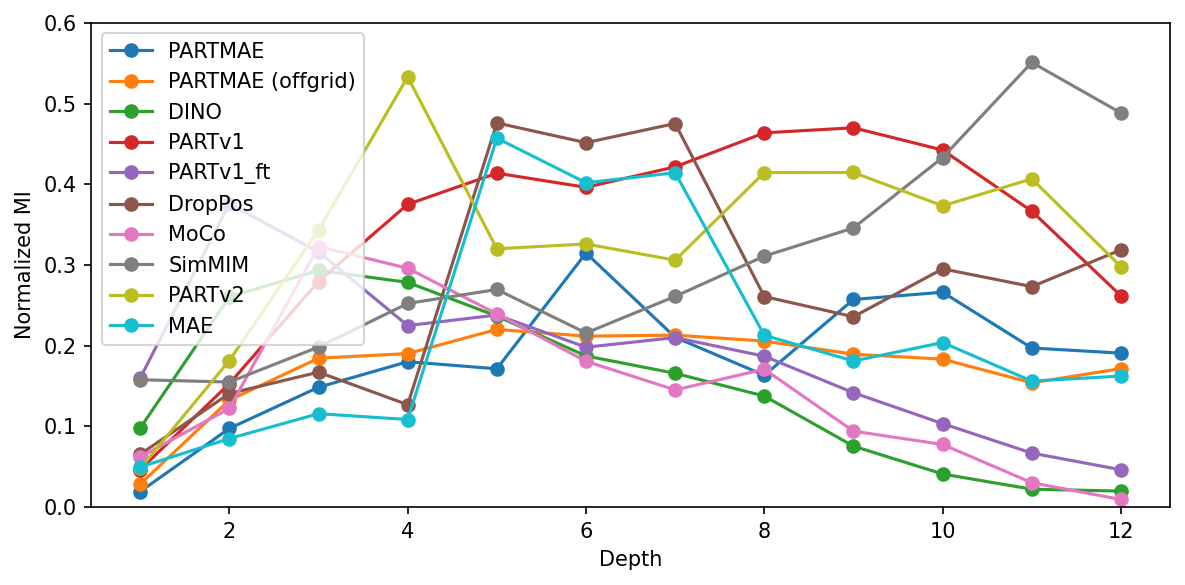

In [14]:
import matplotlib.pyplot as plt
from timm.utils import AverageMeter

def calculate_nmi_for_model(model, dataset_test, label):
    encoder_length = len(model.blocks)  # 12 for ViT-B
    nmis = [AverageMeter() for _ in range(encoder_length)]

    for idx, (xs, _) in enumerate(dataset_test):
        xs = xs.cuda()

        head_name = "clf" if label == "PARTv1_ft" else "head"
        act = ActivationCache(head_name)
        act.hook(model)
        
        with torch.no_grad():
            _ = model(xs)

        attns = act.get_attns() 
        attns = torch.stack(attns)

        def get_res_perfect_square(x):
            return x - int(x**0.5)**2
        
        b = get_res_perfect_square(attns.shape[-2])
        for i, attn in enumerate([attn for attn in attns if attn is not None]):
            attn = attn[:, :, b:, b:]  # drop cls token
            attn = attn + 1e-8
            attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
            attn = attn.cpu().float()
            
            nmi = calculate_nmi(attn)
            nmis[i].update(torch.mean(nmi, dim=0))  # average w.r.t. batch
            
        if idx > -1:
            break
    
    return [torch.mean(nmi.avg) for nmi in nmis]


models = {
    "PARTMAE": load_partmae,
    "PARTMAE (offgrid)": load_partmae_offgrid,
    "DINO": load_dino,
    # "DINOv2": load_dinov2,
    "PARTv1": partial(load_part_v1, "../../artifacts/tasks_2/9u72ktsg6k/artifacts/checkpoint_epoch_200.pth",  "../../../ogPART"),
    "PARTv1_ft": partial(load_part_v1, "../../artifacts/tasks_2/9u72ktsg6k/artifacts/checkpoint_ft_epoch_200.pth",  "../../../ogPART"),
    "DropPos": load_droppos,
    "MoCo": load_moco,
    "SimMIM": load_simmmim,
    "PARTv2": load_part,
    "MAE": load_mae,
}


# Create figure with subplots side by side
fig, ax = plt.subplots(1, figsize=(8, 4), dpi=150)

ax.set_xlabel("Depth")
ax.set_ylabel("Normalized MI")

# Plot for each model
for (name, loader) in models.items():
    model = loader()
    nmis = calculate_nmi_for_model(model, dataset_test, name)
    ax.plot(range(1, 13), nmis, marker="o", label=name)
    ax.set_ylim(top=0.6, bottom=0.0)
    # ax.set_title(name)

ax.legend()
plt.tight_layout()
plt.show()

## Attention Distance

In [15]:
# build off the implementation of https://github.com/sayakpaul/probing-vits
import numpy as np

def compute_distance_matrix(patch_size, num_patches, length):
    """Helper function to compute distance matrix."""
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j: # zero distance
                continue

            xi, yi = (int(i/length)), (i % length)
            xj, yj = (int(j/length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix

def calculate_mean_attention_dist(patch_size, attention_weights):
    """ The attention_weights shape = (batch, num_heads, num_patches, num_patches)"""
    
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert (length**2 == num_patches), ("Num patches is not perfect square")

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(mean_distances, axis=-1) # sum along last axis to get average distance per token
    mean_distances = np.mean(mean_distances, axis=-1) # now average across all the tokens

    return torch.tensor(mean_distances)

INFO:timm.models._builder:Loading pretrained weights from file (../../artifacts/model-2knf0d16:v0/backbone.ckpt)
INFO:timm.models._helpers:Loaded  from checkpoint '../../artifacts/model-2knf0d16:v0/backbone.ckpt'
INFO:timm.models._builder:Missing keys (head.weight, head.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


torch.Size([12, 59, 12, 197, 197])
1


INFO:timm.models._builder:Loading pretrained weights from file (../../artifacts/model-oj0seccv:v0/backbone.ckpt)
INFO:timm.models._helpers:Loaded  from checkpoint '../../artifacts/model-oj0seccv:v0/backbone.ckpt'
INFO:timm.models._builder:Missing keys (head.weight, head.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


torch.Size([12, 59, 12, 197, 197])
1
torch.Size([12, 59, 12, 197, 197])
1
torch.Size([12, 59, 12, 197, 197])
1
torch.Size([12, 59, 12, 197, 197])
1
torch.Size([12, 59, 12, 197, 197])
1
=> merge config from ../../src/models/components/cl_vs_mim/simmim_pretrain__vit_base__img224__800ep.yaml
torch.Size([12, 59, 12, 197, 197])
1
torch.Size([12, 59, 12, 196, 196])
0


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.mae)
INFO:timm.models._hub:[timm/vit_base_patch16_224.mae] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


torch.Size([12, 59, 12, 197, 197])
1


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.dino)
INFO:timm.models._hub:[timm/vit_base_patch16_224.dino] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


torch.Size([12, 59, 12, 197, 197])
1


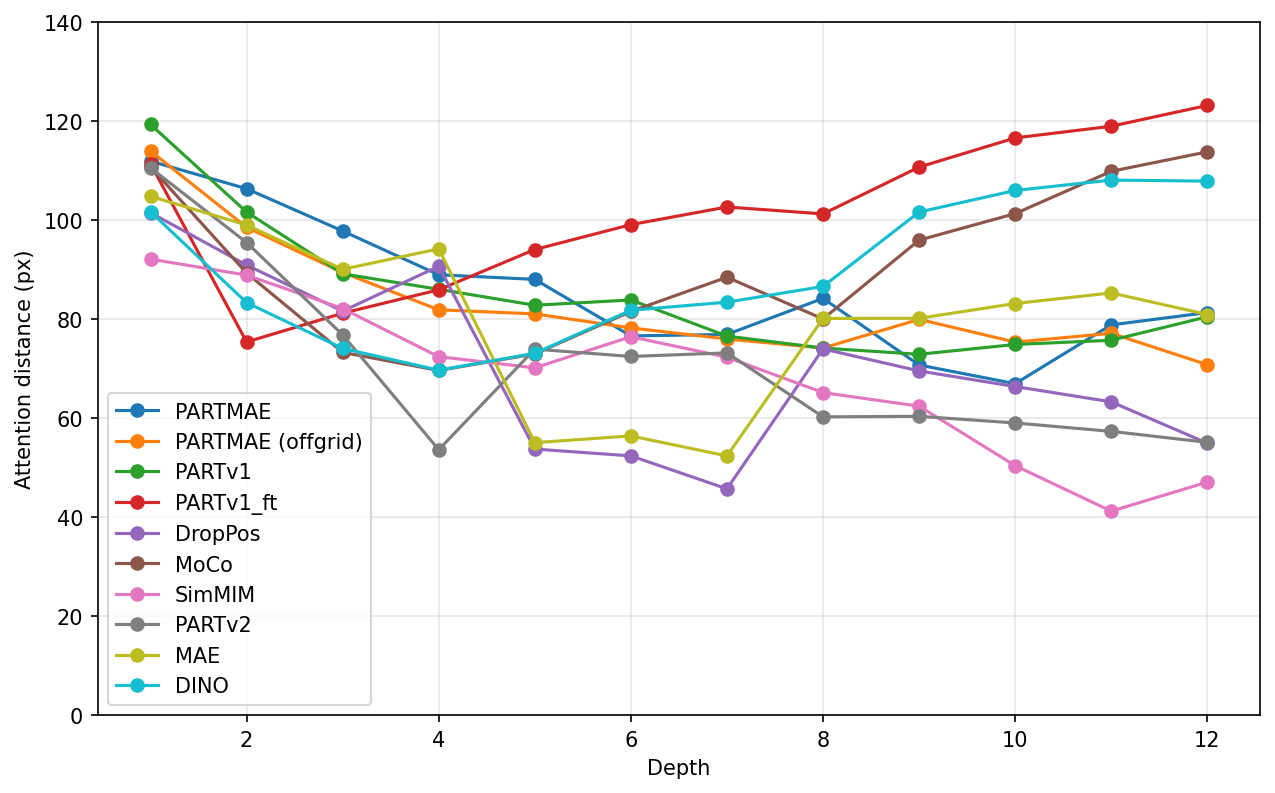

In [16]:
def calculate_distances(model, label: str):
    encoder_length = len(model.blocks)
    distances = [AverageMeter() for _ in range(encoder_length)]

    for idx, (xs, _) in enumerate(dataset_test):
        xs = xs.cuda()
        head_name = "clf" if label == "PARTv1_ft" else "head"
        act = ActivationCache(head_name)
        act.hook(model)
        with torch.no_grad():
            _ = model(xs)

        attns = act.get_attns()
        # stack attns
        attns = torch.stack(attns)
        print(attns.shape)
        # print(act.cache[f"blocks.0.attn.attn_drop"]["input"][0].shape)
        # print(act.cache[f"blocks.0.attn.attn_drop"]["output"].shape)
        def get_res_perfect_square(x):
            # given x = a^2 + b
            # return b
            return x - int(x**0.5)**2
        
        b = get_res_perfect_square(attns.shape[-2])
        print(b)
            
        for i, attn in enumerate([attn for attn in attns if attn is not None]):    
            # remove cls token
            # attn = attn[:,:,1:,1:]
            # remove the first k patches so that the distance matrix is square
            attn = attn[:,:,b:,b:]


        
            attn = attn + 1e-32
            attn = attn / attn.sum(dim=-1, keepdim=True)
            attn = attn.cpu().float().detach().numpy()

            distance = calculate_mean_attention_dist(patch_size=16, attention_weights=attn)
            distances[i].update(torch.mean(distance, dim=0))
            
        if idx > -1:
            break
    
    return [torch.mean(distance.avg) for distance in distances]

models = {
    "PARTMAE": load_partmae,
    "PARTMAE (offgrid)": load_partmae_offgrid,
    "PARTv1": partial(load_part_v1, "../../artifacts/tasks_2/9u72ktsg6k/artifacts/checkpoint_epoch_200.pth",  "../../../ogPART"),
    "PARTv1_ft": partial(load_part_v1, "../../artifacts/tasks_2/9u72ktsg6k/artifacts/checkpoint_ft_epoch_200.pth",  "../../../ogPART"),
    "DropPos": load_droppos,
    "MoCo": load_moco,
    "SimMIM": load_simmmim,
    "PARTv2": load_part,
    "MAE": load_mae,
    "DINO": load_dino,
    # "DINOv2": load_dinov2,
}
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)
x = range(1, 13)
for label, loader in models.items():
    model = loader()
    # Calculate distances for all models
    distances = calculate_distances(model, label)

    # Plot all curves

    ax.plot(x, distances,label=label, marker='o')

    ax.set_xlabel("Depth")
    ax.set_ylabel("Attention distance (px)")
    ax.set_ylim(top=140, bottom=0)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.show()


## Attention Visualization

In [17]:
import ipywidgets as widgets

def get_res_perfect_square(x):
    # given x = a^2 + b
    # return b
    return x - int(x**0.5)**2

def mark_token(ax, xs, batch, i, j, color='tab:red'):
    import matplotlib.patches as patches
    from einops import rearrange
    
    # Denormalize the image
    img = xs[batch].cpu()
    img = img * torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    img = img + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    img = torch.clamp(img, 0, 1)
    
    ax.imshow(rearrange(img, 'c h w -> h w c'))
    ax.set_axis_off()

    # Create a rectangle patch to visualize the query token
    rect = patches.Rectangle((14 * i, 14 * j), 14, 14, linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

def visualize_attn(ax, model, xs, batch, i, j, depth, head):
    act = ActivationCache("head")
    act.hook(model)
    
    with torch.no_grad():
        _ = model(xs)
    
    attns = act.get_attns()
    attns = torch.stack(attns)
    
    # Get attention map for specific depth and head
    b = get_res_perfect_square(attns.shape[-2])
    attn = attns[depth, batch, head, b:, b:]  # Remove cls token and get specific head
    attn = attn / attn.sum(dim=-1, keepdim=True)  # Normalize
    
    # Reshape attention to image dimensions
    attn = attn[j * 14 + i]
    attn = attn.reshape([14, 14])
    
    ax.imshow(attn.cpu(), cmap="plasma")
    ax.set_axis_off()

def update_plot(model_name, depth, batch, coord_x, coord_y, head):
    model = models[model_name]()
    
    # Get a batch of images
    xs, _ = next(iter(dataset_test))
    xs = xs.cuda()
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot original image with token marker
    mark_token(ax1, xs, batch=batch, i=coord_x, j=coord_y)
    ax1.set_title("Input Image with Query Token")
    
    # Plot attention map
    visualize_attn(ax2, model, xs, batch=batch, i=coord_x, j=coord_y, depth=depth, head=head)
    ax2.set_title(f"Attention Map (Depth {depth}, Head {head})")
    
    plt.tight_layout()
    plt.show()

# Create widgets
model_dropdown = widgets.Dropdown(
    options=list(models.keys()),
    value="PARTMAE",
    description='Model:',
)

depth_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=11,
    step=1,
    description='Depth:',
)

batch_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=63,  # Batch size - 1
    description='Batch:',
)

coord_x_slider = widgets.IntSlider(
    value=7,
    min=0,
    max=13,
    description='X coord:',
)

coord_y_slider = widgets.IntSlider(
    value=7,
    min=0,
    max=13,
    description='Y coord:',
)

head_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=11,
    description='Head:',
)

# Create interactive widget
widgets.interactive(
    update_plot,
    model_name=model_dropdown,
    depth=depth_slider,
    batch=batch_slider,
    coord_x=coord_x_slider,
    coord_y=coord_y_slider,
    head=head_slider
)

interactive(children=(Dropdown(description='Model:', options=('PARTMAE', 'PARTMAE (offgrid)', 'PARTv1', 'PARTv…